# JS_EDA_2018_Traffic_Flow_Counts

### Input file(s):

- 2018_Traffic_Flow_Counts.csv
  - This file can be downloaded locally, or obtained by URL. Both options are provided.
  - This file will be referred to as "flow" throughout this notebook.
- collisions_clean.csv
  - This file contains the Seattle Traffic collision data set. It is used only to study the impact of dropping rows in the Traffic Flow data that do not have compkey values or usable location information.

### Notebook focus:

The focus of this notebook is to prepare the 2018_Traffic_Flow_Counts.csv data to be joined with the Seattle_Streets data set.

- 1) identifies rows with 'compkey' as NULL
   Since the location descriptions don't match the locations in the collisions data, they would not be useful with our traffic collision project. These rows are dropped.
   
- 2) creates a modified version with the compkeys split up as


### Output File:
- 2018_Traffic_Flow_Counts_singlekeys.csv


# Import and notebook setup

In [1]:
import numpy as np
import pandas as pd
import missingno as msno

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

In [2]:
# Change this if you have already downloaded from the following URL to a local folder
# https://data-seattlecitygis.opendata.arcgis.com/datasets/2018-traffic-flow-counts

path_to_2018_Traffic_flow = "https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.csv"
#path_to_2018_Traffic_flow = '../z_misc_NO_CHECKIN/2018_Traffic_Flow_Counts.csv'  # Jamie's path


In [3]:
df_flow = pd.read_csv(path_to_2018_Traffic_flow)
df_collisions = pd.read_csv('../data/collisions_clean.csv')

In [4]:
print(f"df_flow shape:       {df_flow.shape}")            # Expect 1906, 14
print(f"df_collisions shape: {df_collisions.shape}")      # Expect 220436, 41

df_flow shape:       (1906, 14)
df_collisions shape: (220436, 41)


## Review the columns

In [5]:
df_flow.columns = df_flow.columns.str.lower()
df_flow.columns

Index(['objectid', 'compkey', 'stname_ord', 'flowsegid', 'downtown',
       'start_date', 'ampk', 'pmpk', 'awdt', 'adt', 'awdt_rounded',
       'dataquality', 'flags', 'shape_length'],
      dtype='object')

In [6]:
df_flow.isnull().sum()

objectid           0
compkey           14
stname_ord         0
flowsegid          0
downtown           0
start_date         0
ampk            1001
pmpk            1001
awdt               2
adt              482
awdt_rounded       0
dataquality        0
flags           1882
shape_length       0
dtype: int64

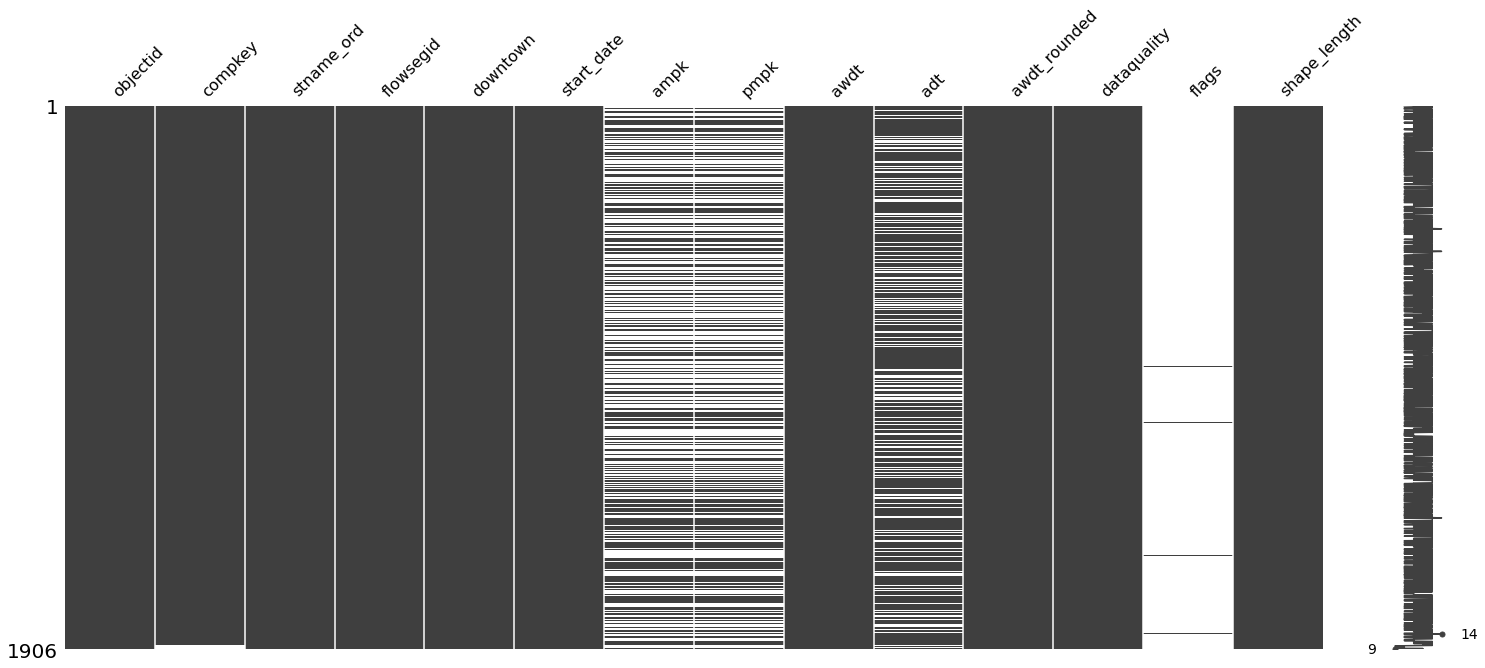

In [7]:
msno.matrix(df_flow)

# Issue #1: null compkey values

In [8]:
# How many are there?
df_flow['compkey'].isnull().sum()

14

In [9]:
# What are they?
df_flow[df_flow['compkey'].isnull()].tail(2)
# Ramps - 9
# PL, AVE, ST - 5

,objectid,compkey,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length
1904,1922,NaN,15TH AVE W,1987,N,2018/06/26 00:00:00+00,2356.0,3017.0,36897.0,35258.0,36000,Study(Normalized),NaN,1380.021208
1905,1923,NaN,W SEA BR EB 4 AV OFF RP,2028,N,1970/01/01 00:00:00+00,NaN,NaN,24000.0,NaN,24000,Estimate,NaN,1458.971527


**Would we have used this data to match to collisions, e.g. based on stname_ord?**

In [10]:
list_collision_locs = list(df_collisions['location'].unique())
list_nokey_flow_locs = list(df_flow.loc[df_flow['compkey'].isnull(),'stname_ord'])

In [11]:
print(f"Collision locations: {len(list_collision_locs)}")
print(f"No-key flow locations: {len(list_nokey_flow_locs)}")

Collision locations: 25158
No-key flow locations: 14


In [12]:
[x for x in list_nokey_flow_locs if x in list_collision_locs]

[]

**Decision**: the 14 flow records without a compkey could not be used with the collision data, so they will be dropped.

In [13]:
# Separate the null compkeys
df_flow_nulls = df_flow[df_flow['compkey'].isnull()]
df_flow_valid = df_flow[df_flow['compkey'].notnull()]

# Issue #2: compkey values include multiple keys

In [14]:
keep_cols = ['objectid','stname_ord', 'flowsegid', 'downtown',
       'start_date', 'ampk', 'pmpk', 'awdt', 'adt', 'awdt_rounded',
       'dataquality', 'flags', 'shape_length'] # just removed compkey

In [15]:
print(df_flow_valid.shape)
df_flow.head()

(1892, 14)


,objectid,compkey,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length
0,1,12221,PINE ST,894,Y,1970/01/01 00:00:00+00,NaN,NaN,8000.0,NaN,8000,Estimate,NaN,322.037238
1,2,2203,15TH AVE W ON RP,1345,N,2015/03/13 00:00:00+00,NaN,NaN,11129.0,10139.0,11100,Study - 13-15,NaN,173.612269
2,3,"17275,17277,17276,17272,17273,17274,17271",NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389
3,4,"23302,23303,23304",W EMERSON ST,1371,N,2018/03/22 00:00:00+00,82.0,99.0,1007.0,1090.0,1000,Study(Normalized),NaN,999.190937
4,5,"19659,19656,19658,19655,19657,19654",S CLOVERDALE ST,126,N,2014/03/25 00:00:00+00,NaN,NaN,4868.0,4615.0,4900,Study - 13-15,NaN,2077.434844


In [16]:
# https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
# (df.set_index(['order_id', 'order_date'])
#    .apply(lambda x: x.str.split(',').explode())
#    .reset_index()) 

In [17]:
df_flow_singular = (df_flow_valid.set_index(keep_cols)
   .apply(lambda x: x.str.split(',').explode())
   .reset_index())

df_flow_singular['compkey'] = df_flow_singular['compkey'].astype(int)

In [18]:
df_flow_singular.shape

(6226, 14)

In [19]:
df_flow_singular.head()

,objectid,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length,compkey
0,1,PINE ST,894,Y,1970/01/01 00:00:00+00,NaN,NaN,8000.0,NaN,8000,Estimate,NaN,322.037238,12221
1,2,15TH AVE W ON RP,1345,N,2015/03/13 00:00:00+00,NaN,NaN,11129.0,10139.0,11100,Study - 13-15,NaN,173.612269,2203
2,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17275
3,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17277
4,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17276


In [20]:
df_flow_singular.to_csv('../data/2018_Traffic_Flow_Counts_singlekeys.csv',index=False)